# CNN for classifying real-world Dogs and Cats images



## Initialization

In [1]:
# Load libraries

# OS
import time
import itertools
from glob import glob
from random import shuffle, seed

# Data manipulation
import numpy as np
import cv2
import imgaug
import imgaug.augmenters as iaa
from google.colab import files

# Data visualization
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sns
from PIL import Image

# Modeling
import torch
import torch.nn.functional as F
import torch.nn as nn
from torch import optim
from torch.utils.data import TensorDataset, Dataset, DataLoader
import torchvision
from torchvision import datasets, transforms, models
from torchsummary import summary

print(torch.__version__)
print(cv2.__version__)
print(imgaug.__version__)
!nvidia-smi # check if GPU is available
%matplotlib inline

2.1.0+cu121
4.8.0
0.4.0
Thu Feb 15 22:09:27 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+-

In [2]:
# Set device to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Running on:", device)

Running on: cuda


In [3]:
# Upload Kaggle Token
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"keneth4","key":"c0c016311b74b86d99e3984089fbd3b3"}'}

In [4]:
# Copy Kaggle Token
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json

kaggle.json


In [5]:
# Download and unzip Cats and Dogs dataset from Kaggle
!kaggle datasets download -d tongpython/cat-and-dog
!unzip cat-and-dog.zip
!ls

Se truncaron las últimas líneas 5000 del resultado de transmisión.
  inflating: training_set/training_set/cats/cat.3705.jpg  
  inflating: training_set/training_set/cats/cat.3706.jpg  
  inflating: training_set/training_set/cats/cat.3707.jpg  
  inflating: training_set/training_set/cats/cat.3708.jpg  
  inflating: training_set/training_set/cats/cat.3709.jpg  
  inflating: training_set/training_set/cats/cat.371.jpg  
  inflating: training_set/training_set/cats/cat.3710.jpg  
  inflating: training_set/training_set/cats/cat.3711.jpg  
  inflating: training_set/training_set/cats/cat.3712.jpg  
  inflating: training_set/training_set/cats/cat.3713.jpg  
  inflating: training_set/training_set/cats/cat.3714.jpg  
  inflating: training_set/training_set/cats/cat.3715.jpg  
  inflating: training_set/training_set/cats/cat.3716.jpg  
  inflating: training_set/training_set/cats/cat.3717.jpg  
  inflating: training_set/training_set/cats/cat.3718.jpg  
  inflating: training_set/training_set/cats/cat.3

In [35]:
# Save dataset paths
train_path = '/content/training_set/training_set'
test_path = '/content/test_set/test_set'

In [36]:
# Create Dataset class to fetch images and labels
class CatsDogs(Dataset):
    def __init__(self, folder):
        cats = glob(f'{folder}/cats/*.jpg')
        dogs = glob(f'{folder}/dogs/*.jpg')
        self.fpaths = cats + dogs
        seed(10)
        shuffle(self.fpaths)
        self.labels = [fpath.split('/')[-1].startswith('dog') for fpath in self.fpaths] # Dog = 1, Cat = 0

    def __len__(self): return len(self.fpaths)

    def __getitem__(self, idx):
        _file = self.fpaths[idx]
        label = self.labels[idx]
        image = (cv2.imread(_file)[:,:,::-1]) # Read image and reverse channels so it matches the input format
        image = cv2.resize(image, (224,224))
        return torch.tensor(image/255).permute(2,0,1).to(device).float(), torch.tensor([label]).float().to(device)

In [37]:
# Inspect a random image
data = CatsDogs(train_path)
image, label = data[200]
len(data)

8005

In [38]:
# Create function to plot an image
def plot_img(img, label):
    plt.imshow(img)
    plt.title(label, fontsize=16)
    plt.axis('off')
    plt.show()

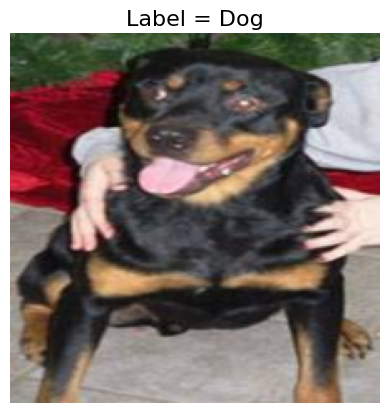

In [39]:
# Plot the image
true_label = 'Dog' if label.item() == 1 else 'Cat'
plot_img(image.permute(1,2,0).cpu(), f'Label = {true_label}')

In [40]:
# Create function to define a convolution layer pipeline
def conv_layer(input_channels, output_channels, kernel_size, stride=1):
  return nn.Sequential(
      nn.Conv2d(input_channels, output_channels, kernel_size, stride),
      nn.ReLU(),
      nn.BatchNorm2d(output_channels),
      nn.MaxPool2d(2)
  )

In [41]:
# Create function to define model architecture, loss function and optimizer
def create_model():
    model = nn.Sequential(
        conv_layer(3, 64, 3),
        conv_layer(64, 512, 3),
        conv_layer(512, 512, 3),
        conv_layer(512, 512, 3),
        conv_layer(512, 512, 3),
        conv_layer(512, 512, 3),
        nn.Flatten(),
        nn.Linear(512, 1),
        nn.Sigmoid()
    ).to(device)
    loss_fn = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    return model, loss_fn, optimizer

In [42]:
# Print model summary
model, _, _ = create_model()
summary(model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 222, 222]           1,792
              ReLU-2         [-1, 64, 222, 222]               0
       BatchNorm2d-3         [-1, 64, 222, 222]             128
         MaxPool2d-4         [-1, 64, 111, 111]               0
            Conv2d-5        [-1, 512, 109, 109]         295,424
              ReLU-6        [-1, 512, 109, 109]               0
       BatchNorm2d-7        [-1, 512, 109, 109]           1,024
         MaxPool2d-8          [-1, 512, 54, 54]               0
            Conv2d-9          [-1, 512, 52, 52]       2,359,808
             ReLU-10          [-1, 512, 52, 52]               0
      BatchNorm2d-11          [-1, 512, 52, 52]           1,024
        MaxPool2d-12          [-1, 512, 26, 26]               0
           Conv2d-13          [-1, 512, 24, 24]       2,359,808
             ReLU-14          [-1, 512,

In [43]:
# Create a function to retrieve the dataloaders
def load_data(batch_size):
    train_dataset = CatsDogs(train_path)
    train_dl = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

    val_dataset = CatsDogs(test_path)
    val_dl = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

    return train_dl, val_dl

In [44]:
# Create a function to train the model on a batch of data
def train_batch(model, x, y, loss_fn, optimizer):
    model.train()
    optimizer.zero_grad()
    y_pred = model(x)
    loss = loss_fn(y_pred, y)
    loss.backward()
    optimizer.step()
    return loss.item()

In [45]:
# Create a function to calculate the accuracy of the model
@torch.no_grad()
def accuracy(model, x, y, threshold=0.5):
    model.eval()
    prediction = model(x)
    is_correct = (prediction > threshold) == y
    return is_correct.cpu().numpy().tolist()

In [46]:
# Create a function to calculate the validation loss
@torch.no_grad()
def val_loss(model, x, y, loss_fn):
    model.eval()
    prediction = model(x)
    val_loss = loss_fn(prediction, y)
    return val_loss.item()

In [47]:
# Train the model
model, loss_fn, optimizer = create_model()
batch_size = 32
train_dl, val_dl = load_data(batch_size)
losses, val_losses, accuracies, val_accuracies = [], [], [], []
start = time.time()
epochs = 5

print(f'Training CNN model for {epochs} epochs')
for epoch in range(epochs):
    print(f"Epoch {epoch+1}")
    epoch_losses, epoch_accuracies, val_epoch_losses, val_epoch_accuracies = [], [], [], []
    # Train on batches
    for x, y in train_dl:
        batch_loss = train_batch(model, x, y, loss_fn, optimizer)
        epoch_losses.append(batch_loss)
        batch_accuracy = accuracy(model, x, y)
        epoch_accuracies.extend(batch_accuracy)

    for x, y in val_dl:
        val_batch_loss = val_loss(model, x, y, loss_fn)
        val_epoch_losses.append(val_batch_loss)
        val_batch_accuracy = accuracy(model, x, y)
        val_epoch_accuracies.extend(val_batch_accuracy)

    epoch_loss = np.array(epoch_losses).mean()
    losses.append(epoch_loss)
    accuracies.append(np.mean(epoch_accuracies))

    val_epoch_loss = np.array(val_epoch_losses).mean()
    val_losses.append(val_epoch_loss)
    val_accuracies.append(np.mean(val_epoch_accuracies))

end = time.time()
print(f"Total training time: {end - start:.2f}s")

Training CNN model for 5 epochs
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Total training time: 925.64s


<ipython-input-48-32a512ed191a>:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()])


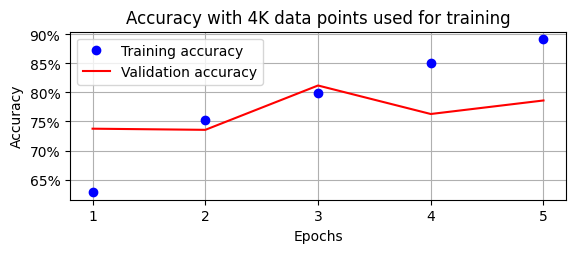

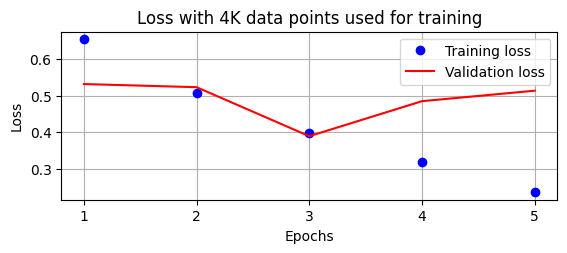

In [48]:
# Plot the accuracy and loss on the training and validation sets
%matplotlib inline
epochs_list = np.arange(1, epochs+1)
plt.subplot(211)
plt.plot(epochs_list, accuracies, 'bo', label='Training accuracy')
plt.plot(epochs_list, val_accuracies, 'r', label='Validation accuracy')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title('Accuracy with 4K data points used for training')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()])
plt.legend()
plt.grid('off')
plt.show()
plt.subplot(212)
plt.plot(epochs_list, losses, 'bo', label='Training loss')
plt.plot(epochs_list, val_losses, 'r', label='Validation loss')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title('Loss with 4K data points used for training')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid('off')
plt.show()

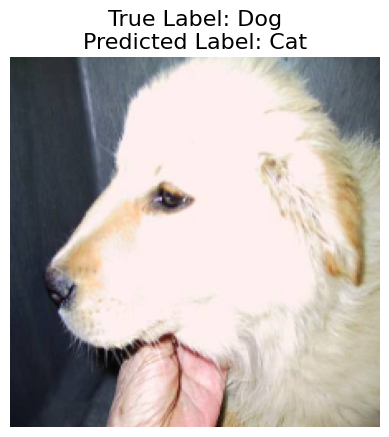

In [49]:
# Fetch a batch of images and their labels
batch_images, batch_labels = next(iter(val_dl))

# Select the first image and label from the batch
image = batch_images[0].unsqueeze(0)  # Add batch dimension
true_label = 'Dog' if batch_labels[0] == 1 else 'Cat'

# Make a prediction
pred = model(image)

# Get labels
threshold = 0.5
predicted_label = 'Dog' if pred >= threshold else 'Cat'

# Plot the image
plot_img(image.squeeze().permute(1, 2, 0).cpu().numpy(), f'True Label: {true_label}\nPredicted Label: {predicted_label}')

## Transfer Learning using VGG16 pretrained model

In [50]:
# Modify Dataset class to fetch only 500 images and labels form the dataset and normalize the images
class CatsDogs(Dataset):
    def __init__(self, folder):
        cats = glob(f'{folder}/cats/*.jpg')
        dogs = glob(f'{folder}/dogs/*.jpg')
        self.fpaths = cats[:500] + dogs[:500]
        self.normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225]) # Normalization used in VGG16
        seed(10)
        shuffle(self.fpaths)
        self.labels = [fpath.split('/')[-1].startswith('dog') for fpath in self.fpaths] # Dog = 1, Cat = 0

    def __len__(self): return len(self.fpaths)

    def __getitem__(self, idx):
        _file = self.fpaths[idx]
        label = self.labels[idx]
        image = (cv2.imread(_file)[:,:,::-1]) # Read image and reverse channels so it matches the input format (B, C, H, W)
        image = cv2.resize(image, (224,224))
        image = torch.tensor(image/255)
        image = image.permute(2,0,1)
        image = self.normalize(image)
        return image.float().to(device), torch.tensor([label]).float().to(device)

In [51]:
# Inspect a random image
data = CatsDogs(train_path)
image, label = data[200]
len(data)

1000

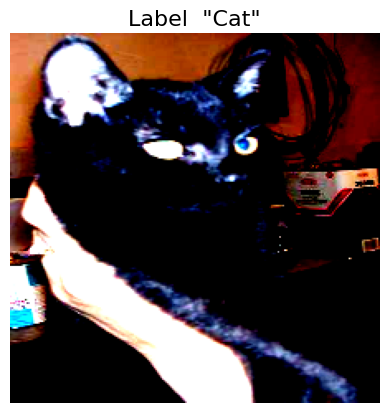

In [52]:
# Plot the image
true_label = 'Dog' if label == 1 else 'Cat'
plot_img(image.permute(1,2,0).cpu(), f'Label  "{true_label}"')

In [53]:
# Create a function to load the VGG16 model and replace the last layers according to our needs
def load_model():
    model = models.vgg16(weights='IMAGENET1K_V1')
    for param in model.parameters():
        param.requires_grad = False # Freeze all layers
    model.avgpool = nn.AdaptiveAvgPool2d(output_size=(1,1))
    model.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(512, 128),
        nn.ReLU(),
        nn.Dropout(),
        nn.Linear(128, 1),
        nn.Sigmoid()
    )
    loss_fn = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    return model.to(device), loss_fn, optimizer

In [54]:
# Print model summary
model, _, _ = load_model()
summary(model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

In [55]:
# Train the model
model, loss_fn, optimizer = load_model()
batch_size = 32
train_dl, val_dl = load_data(batch_size)
losses, val_losses, accuracies, val_accuracies = [], [], [], []
start = time.time()
epochs = 5

print(f'Training VGG16 model for {epochs} epochs')
for epoch in range(epochs):
    print(f"Epoch {epoch+1}")
    epoch_losses, epoch_accuracies, val_epoch_losses, val_epoch_accuracies = [], [], [], []
    # Train on batches
    for x, y in train_dl:
        batch_loss = train_batch(model, x, y, loss_fn, optimizer)
        epoch_losses.append(batch_loss)
        batch_accuracy = accuracy(model, x, y)
        epoch_accuracies.extend(batch_accuracy)

    for x, y in val_dl:
        val_batch_loss = val_loss(model, x, y, loss_fn)
        val_epoch_losses.append(val_batch_loss)
        val_batch_accuracy = accuracy(model, x, y)
        val_epoch_accuracies.extend(val_batch_accuracy)

    epoch_loss = np.array(epoch_losses).mean()
    losses.append(epoch_loss)
    accuracies.append(np.mean(epoch_accuracies))

    val_epoch_loss = np.array(val_epoch_losses).mean()
    val_losses.append(val_epoch_loss)
    val_accuracies.append(np.mean(val_epoch_accuracies))

end = time.time()
print(f"Total training time: {end - start:.2f}s")

Training VGG16 model for 5 epochs
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Total training time: 140.14s


<ipython-input-56-af43dbed4128>:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()])


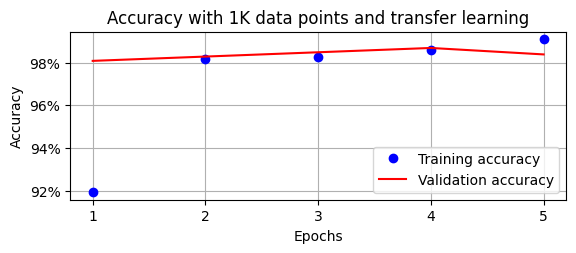

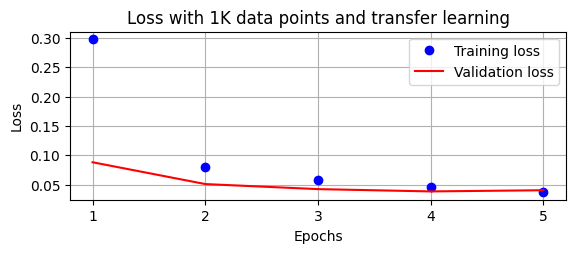

In [56]:
# Plot the accuracy and loss on the training and validation sets
%matplotlib inline
epochs_list = np.arange(1, epochs+1)
plt.subplot(211)
plt.plot(epochs_list, accuracies, 'bo', label='Training accuracy')
plt.plot(epochs_list, val_accuracies, 'r', label='Validation accuracy')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title('Accuracy with 1K data points and transfer learning')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()])
plt.legend()
plt.grid('off')
plt.show()
plt.subplot(212)
plt.plot(epochs_list, losses, 'bo', label='Training loss')
plt.plot(epochs_list, val_losses, 'r', label='Validation loss')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title('Loss with 1K data points and transfer learning')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid('off')
plt.show()

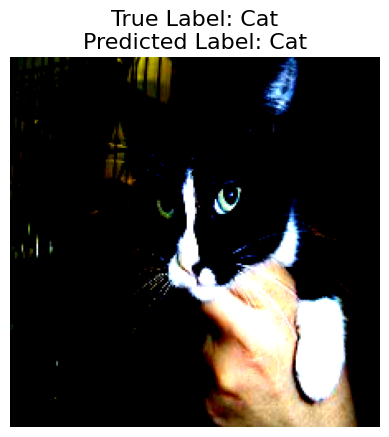

In [57]:
# Fetch a batch of images and their labels
batch_images, batch_labels = next(iter(val_dl))

# Select the first image and label from the batch
image = batch_images[0].unsqueeze(0)  # Add batch dimension
true_label = 'Dog' if batch_labels[0] == 1 else 'Cat'

# Make a prediction
pred = model(image)

# Get labels
threshold = 0.5
predicted_label = 'Dog' if pred >= threshold else 'Cat'

# Plot the image
plot_img(image.squeeze().permute(1, 2, 0).cpu().numpy(), f'True Label: {true_label}\nPredicted Label: {predicted_label}')

## Transfer Learning using ResNet18 pretrained model

In [58]:
# Create a function to load the ResNet18 model and replace the last layers according to our needs
def load_model():
    model = models.resnet18(weights='IMAGENET1K_V1')
    for param in model.parameters():
        param.requires_grad = False # Freeze all layers
    model.avgpool = nn.AdaptiveAvgPool2d(output_size=(1,1))
    model.fc = nn.Sequential(
        nn.Flatten(),
        nn.Linear(512, 128),
        nn.ReLU(),
        nn.Dropout(0.2),
        nn.Linear(128, 1),
        nn.Sigmoid()
    )
    loss_fn = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    return model.to(device), loss_fn, optimizer


In [59]:
# Print model summary
model, _, _ = load_model()
summary(model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

In [60]:
# Train the model
model, loss_fn, optimizer = load_model()
batch_size = 32
train_dl, val_dl = load_data(batch_size)
losses, val_losses, accuracies, val_accuracies = [], [], [], []
start = time.time()
epochs = 5

print(f'Training ResNet18 model for {epochs} epochs')
for epoch in range(epochs):
    print(f"Epoch {epoch+1}")
    epoch_losses, epoch_accuracies, val_epoch_losses, val_epoch_accuracies = [], [], [], []
    # Train on batches
    for x, y in train_dl:
        batch_loss = train_batch(model, x, y, loss_fn, optimizer)
        epoch_losses.append(batch_loss)
        batch_accuracy = accuracy(model, x, y)
        epoch_accuracies.extend(batch_accuracy)

    for x, y in val_dl:
        val_batch_loss = val_loss(model, x, y, loss_fn)
        val_epoch_losses.append(val_batch_loss)
        val_batch_accuracy = accuracy(model, x, y)
        val_epoch_accuracies.extend(val_batch_accuracy)

    epoch_loss = np.array(epoch_losses).mean()
    losses.append(epoch_loss)
    accuracies.append(np.mean(epoch_accuracies))

    val_epoch_loss = np.array(val_epoch_losses).mean()
    val_losses.append(val_epoch_loss)
    val_accuracies.append(np.mean(val_epoch_accuracies))

end = time.time()
print(f"Total training time: {end - start:.2f}s")

Training ResNet18 model for 5 epochs
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Total training time: 73.42s


<ipython-input-61-af43dbed4128>:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()])


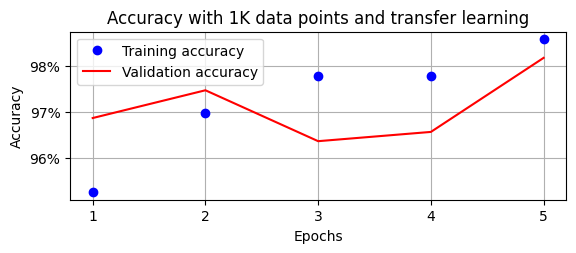

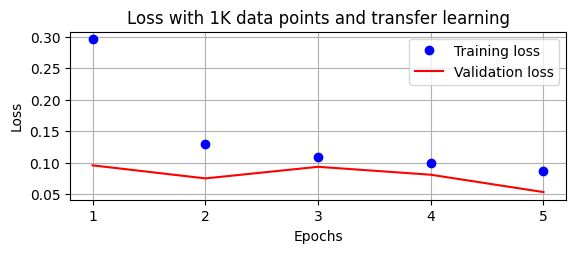

In [61]:
# Plot the accuracy and loss on the training and validation sets
%matplotlib inline
epochs_list = np.arange(1, epochs+1)
plt.subplot(211)
plt.plot(epochs_list, accuracies, 'bo', label='Training accuracy')
plt.plot(epochs_list, val_accuracies, 'r', label='Validation accuracy')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title('Accuracy with 1K data points and transfer learning')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()])
plt.legend()
plt.grid('off')
plt.show()
plt.subplot(212)
plt.plot(epochs_list, losses, 'bo', label='Training loss')
plt.plot(epochs_list, val_losses, 'r', label='Validation loss')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title('Loss with 1K data points and transfer learning')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid('off')
plt.show()

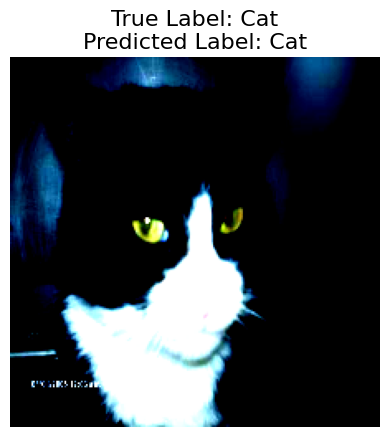

In [62]:
# Fetch a batch of images and their labels
batch_images, batch_labels = next(iter(val_dl))

# Select the first image and label from the batch
image = batch_images[0].unsqueeze(0)  # Add batch dimension
true_label = 'Dog' if batch_labels[0] == 1 else 'Cat'

# Make a prediction
pred = model(image)

# Get labels
threshold = 0.5
predicted_label = 'Dog' if pred >= threshold else 'Cat'

# Plot the image
plot_img(image.squeeze().permute(1, 2, 0).cpu().numpy(), f'True Label: {true_label}\nPredicted Label: {predicted_label}')